Implementing VG-11

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from matplotlib import pyplot as plt

In [2]:
%run util.ipynb

In [3]:
class VGGNet11(nn.Module):
    
    def __init__(self, img_size=224, channels=(1, 64, 128, 256, 512, 512)):
        super().__init__()
        assert img_size % 32 == 0
        self.net = nn.Sequential(
            self.get_conv_block(1, channels[0], channels[1]),
            self.get_conv_block(1, channels[1], channels[2]),
            self.get_conv_block(2, channels[2], channels[3]),
            self.get_conv_block(2, channels[3], channels[4]),
            self.get_conv_block(2, channels[4], channels[5]),
            nn.Flatten(),
            nn.Linear(in_features = (img_size // 32) * (img_size // 32) * channels[5], out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=10))
        
        self.net.apply(self.init_weights)
        
        
    
    def get_conv_block(self, num_conv: int, in_channels: int, out_channels: int):
        layers = []
        for _ in range(num_conv):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X)
    
    def init_weights(self, layer):
        """ To be applied to a net """
        if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(layer.weight)

We train a small version for faster computation, since we're only using Fashion-MNIST here anyways

In [4]:
net = VGGNet11(img_size=224, channels=(1, 16, 32, 64, 128, 128))

Check that the dimensions line up

In [5]:
x = torch.randn(size=(1, 1, 224, 224))

for blk in net.net:
    x = blk(x)
    print(blk.__class__.__name__, "has shape:", x.shape)

Sequential has shape: torch.Size([1, 16, 112, 112])
Sequential has shape: torch.Size([1, 32, 56, 56])
Sequential has shape: torch.Size([1, 64, 28, 28])
Sequential has shape: torch.Size([1, 128, 14, 14])
Sequential has shape: torch.Size([1, 128, 7, 7])
Flatten has shape: torch.Size([1, 6272])
Linear has shape: torch.Size([1, 4096])
ReLU has shape: torch.Size([1, 4096])
Dropout has shape: torch.Size([1, 4096])
Linear has shape: torch.Size([1, 4096])
ReLU has shape: torch.Size([1, 4096])
Dropout has shape: torch.Size([1, 4096])
Linear has shape: torch.Size([1, 10])


Training time!

In [6]:
lr, num_epochs, batch_size = 0.05, 6, 256
all_iter, train_iter, val_iter, test_iter = get_fashion_mnist_iters(batch_size=batch_size)

loss 0.300, train acc 0.906, test acc 0.889


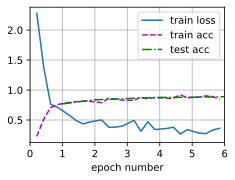

In [7]:
optimizer=torch.optim.SGD(net.parameters(), lr=lr)

train(net, all_iter, test_iter, num_epochs, lr, optimizer)

What happens if we use 96x96 images, and also double the batch size?

In [10]:
all_iter, train_iter, val_iter, test_iter = get_fashion_mnist_iters(batch_size=256, resize=96)
num_epochs=3
net = VGGNet11(img_size=96, channels=(1, 16, 32, 64, 128, 128))

loss 2.308, train acc 0.042, test acc 0.100


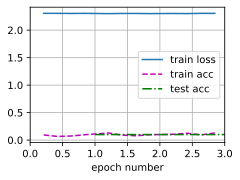

In [11]:
train(net, all_iter, test_iter, num_epochs, lr, optimizer)

Not so good. Let's check out how the images look now vs before

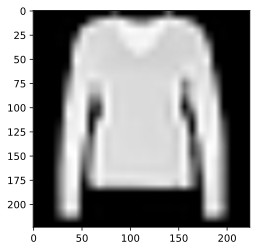

In [12]:
earlier_iter, _, _, _ = get_fashion_mnist_iters()
earlier_img = next(enumerate(earlier_iter))[1][0][0][0]
plt.imshow(earlier_img, cmap='gray')

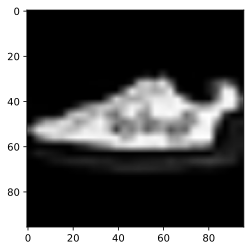

In [13]:
later_iter, _, _, _ = get_fashion_mnist_iters(resize=96)
later_img = next(enumerate(later_iter))[1][0][0][0]
plt.imshow(later_img, cmap='gray')

Looks fine to me - no obvious issues with the resizing.

Let's try the training using the d2l library's methods to see if there's an issue in my implementation of them.

loss 0.519, train acc 0.810, test acc 0.814
4263.8 examples/sec on cuda:0


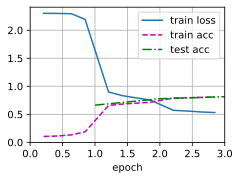

In [14]:
dtrain_iter, dtest_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, dtrain_iter, dtest_iter, num_epochs, lr)

OK, so it looks like something in my implementation of either the data fetching or the training is off. 

Well, let's try their training method with my data fetching method.

loss 0.483, train acc 0.821, test acc 0.828
4302.2 examples/sec on cuda:0


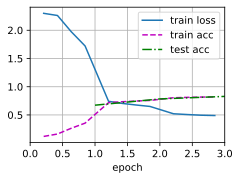

In [15]:
train_iter, _, _, test_iter = get_fashion_mnist_iters(batch_size=256, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

Looks like my training method is to blame. 

From the below, apparently if I choose not to pass in an optimizer and let the default one be defined inside the training function, things work fine again.

loss 0.527, train acc 0.823, test acc 0.783


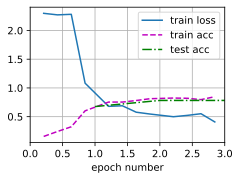

In [16]:
all_iter, train_iter, val_iter, test_iter = get_fashion_mnist_iters(batch_size=256, resize=96)
net = VGGNet11(img_size=96, channels=(1, 16, 32, 64, 128, 128))
train(net, all_iter, test_iter, num_epochs, lr, optimizer=None)

One theory is that defining the optimizer has to be done after the network is sent to the device. I'm not sure why this would only affect the 96x96 image case. But let's see what happens if the optimizer is defined inside the training function, but before the network is sent to the device - if the theory is correct then this should fail.

In [17]:
def train_local(net, train_iter, test_iter, num_epochs, lr, optimizer=None, device=d2l.try_gpu()):
    """
    Trains a network 'net'. Defines/attaches the optimizer before the network is moved to the device.
    """
    # 1: initialise weights
#     net.apply(net.init_weights)
    def init_weights_test(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights_test)
    
    if optimizer is None:
        optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)

    # 2: move model to device for training
    net.to(device)
    
    # 3: set up optimizer, loss function, and animation stuff
    loss = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel="epoch number", xlim=[0, num_epochs], legend=["train loss", "train acc", "test acc"])
    
    # 4: training loop
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            net.train()
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # temporarily disable grad to calculate metrics
            with torch.no_grad():
                train_loss = l
#                 import ipdb; ipdb.set_trace()
                _, preds = torch.max(y_hat, 1)
                train_acc = ((preds == y).sum()) / float(X.shape[0])
            if (i + 1) % 50 == 0:
                animator.add(epoch + (i / len(train_iter)), (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')

loss 0.416, train acc 0.844, test acc 0.831


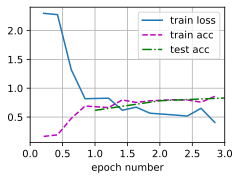

In [18]:
all_iter, train_iter, val_iter, test_iter = get_fashion_mnist_iters(batch_size=256, resize=96)
net = VGGNet11(img_size=96, channels=(1, 16, 32, 64, 128, 128))
train_local(net, all_iter, test_iter, num_epochs, lr, optimizer=None)

This works fine, so defining the optimizer before the network is sent to the device is not the problem in itself.

Ah - it appears the answer is just simple stupidity. I was creating the optimizer object attached to a previously-created net object, and then creating the new net object *after* that - so the optimizer wasn't attached to the network being used. Of course it didn't work. If I do it right it should work:

loss 0.440, train acc 0.844, test acc 0.805


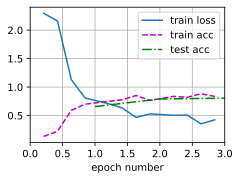

In [19]:
all_iter, train_iter, val_iter, test_iter = get_fashion_mnist_iters(batch_size=256, resize=96)
net = VGGNet11(img_size=96, channels=(1, 16, 32, 64, 128, 128))
optimizer=torch.optim.SGD(net.parameters(), lr=lr)
train_local(net, all_iter, test_iter, num_epochs, lr, optimizer=optimizer)